C:\Users\hpl886\Documents\Exjobb
C:\Users\hpl886\Documents\Exjobb\data\raw
    Span Beam  Coordinate  Strain   Temp Position  Adjusted_Coordinate  \
0    N13    B       12.64     110  -11.5  1312.64                63.79   
1    N13    B       12.54     116  -11.5  1312.54                63.69   
2    N13    B       12.44     121  -11.5  1312.44                63.59   
3    N13    B       12.34     119  -11.5  1312.34                63.49   
4    N13    B       12.24     113  -11.3  1312.24                63.39   
..   ...  ...         ...     ...    ...      ...                  ...   
626  N10    B        1.32      13   -5.8  1001.32                 0.41   
627  N10    B        1.21      11   -5.8  1001.21                 0.30   
628  N10    B        1.11       7   -5.8  1001.11                 0.20   
629  N10    B        1.01       4   -5.8  1001.01                 0.10   
630  N10    B        0.91       2   -5.8  1000.91                 0.00   

     Span_Number  
0           13.0 

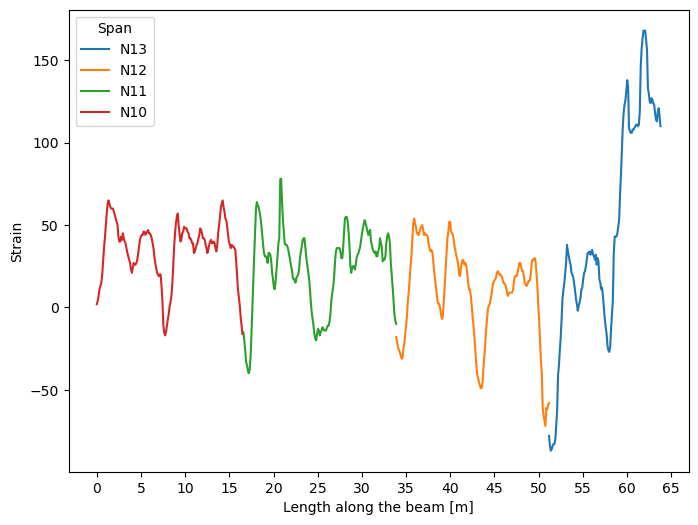

,Span,Beam,Coordinate,Strain,Temp,Position,Adjusted_Coordinate,Span_Number
0,N13,B,12.64,110,-11.5,1312.64,63.79,13.0
1,N13,B,12.54,116,-11.5,1312.54,63.69,13.0
2,N13,B,12.44,121,-11.5,1312.44,63.59,13.0
3,N13,B,12.34,119,-11.5,1312.34,63.49,13.0
4,N13,B,12.24,113,-11.3,1312.24,63.39,13.0


In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np

# Add the root project directory to the Python path
project_root = Path.cwd().parent  # This will get the project root since the notebook is in 'notebooks/'
sys.path.append(str(project_root))

from configs.path_config import RAW_DATA_DIR
print(RAW_DATA_DIR)

def read_text_file(RAW_DATA_DIR, timestamp, file_name):
    """
    Reads a text file from a specified timestamp folder using pandas, 
    handling mixed delimiters (commas and whitespace) properly, 
    and dynamically naming columns.
    """

    folder_path = Path(RAW_DATA_DIR) / timestamp
    file_path = folder_path / file_name

    if not file_path.exists():
        print(f"Error: The file '{file_name}' does not exist in the folder '{folder_path}'.")
        return None

    data = []
    with file_path.open('r') as file:
        for line in file:
            parts = line.strip().split(',')
            processed_parts = parts[:2] + parts[2].split()
            data.append(processed_parts)

    df = pd.DataFrame(data)

    num_columns = df.shape[1]
    
    # Define the first two column names
    column_names = ["Span", "Beam"]
    
    # If there's at least 3 columns, assign "Co-ordinate" to the third column
    if num_columns > 2:
        column_names.append("Coordinate")
    
    remaining_columns = [f"Column_{i+1}" for i in range(num_columns - len(column_names))]

    df.columns = column_names + remaining_columns

    df.drop(df.columns[[4,5]], axis=1, errors='ignore', inplace=True)
    df.rename(columns={'Column_1': 'Strain', 'Column_4': 'Temp', 'Column_5': 'Position'}, inplace=True)

    df["Coordinate"] = pd.to_numeric(df["Coordinate"], errors="coerce")
    df["Strain"] = pd.to_numeric(df["Strain"], errors="coerce")

    # Define which columns to use for plotting, check the excel for what column
    y_col = "Strain"   # Y-axis 

    x_col = "Coordinate" 
    df["Adjusted_Coordinate"] = df[x_col]  

    df["Span_Number"] = df["Span"].str.extract(r'(\d+)').astype(float)
    span_order = df.groupby("Span")["Span_Number"].first().sort_values().index.tolist()

    offset = 0

    for span in span_order:
        span_mask = df["Span"] == span
        if span_mask.any():
            min_coord = df.loc[span_mask, x_col].min()  
            df.loc[span_mask, "Adjusted_Coordinate"] += offset - min_coord
            offset = df.loc[span_mask, "Adjusted_Coordinate"].max()

    return df

# Enter time stemp and loop name
# RAW_DATA_DIR = '../0_GAB'  
timestamp = '20141129120000'  # Time stamp
file = 'N-B_Far_Comp.txt'  # Name of loop
df = read_text_file(RAW_DATA_DIR, timestamp, file)

print(df)

plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x="Adjusted_Coordinate", y="Strain", hue="Span", linestyle="-") #add markers: marker="o",

print(df)

plt.xlabel('Length along the beam [m]')  
plt.ylabel('Strain')  
tick_spacing = 5  # Adjust this value to control the frequency of ticks
x_min, x_max = df["Adjusted_Coordinate"].min(), df["Adjusted_Coordinate"].max()
plt.xticks(np.arange(x_min, x_max + tick_spacing, tick_spacing)) 
plt.yticks()  
plt.show()

df.head()



In [100]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Add the root project directory to the Python path
project_root = Path.cwd().parent  # This will get the project root since the notebook is in 'notebooks/'
from configs.path_config import CONFIG_DIR, RAW_DATA_DIR

def get_coordinates(RAW_DATA_DIR, timestamp, file_name):
    """
    Reads a text file from a specified timestamp folder using pandas, 
    handling mixed delimiters (commas and whitespace) properly, 
    and dynamically naming columns.
    """
    file_path = Path(RAW_DATA_DIR) / timestamp / file_name

    if not file_path.exists():
        print(f'Error: The file {file_name} does not exist')
        return None

    data = []
    with file_path.open('r') as file:
        for line in file:
            parts = line.strip().split(',')
            processed_parts = parts[:2] + parts[2].split()
            data.append(processed_parts)

    df = pd.DataFrame(data)

    num_columns = df.shape[1]
    
    # Define the first two column names
    column_names = ["Span", "Beam"]
    
    # If there's at least 3 columns, assign "Coordinate" to the third column
    if num_columns > 2:
        column_names.append("Coordinate")
    
    remaining_columns = [f"Column_{i+1}" for i in range(num_columns - len(column_names))]

    df.columns = column_names + remaining_columns

    df.drop(df.columns[[4,5]], axis=1, errors='ignore', inplace=True)
    df.rename(columns={'Column_1': 'Strain', 'Column_4': 'Temp', 'Column_5': 'Position'}, inplace=True)

    df["Coordinate"] = pd.to_numeric(df["Coordinate"], errors="coerce")
    df["Strain"] = pd.to_numeric(df["Strain"], errors="coerce")

    # Define which columns to use for plotting, check the excel for what column
    y_col = "Strain"   # Y-axis 

    x_col = "Coordinate" 
    df["Adjusted_Coordinate"] = df[x_col]  

    df["Span_Number"] = df["Span"].str.extract(r'(\d+)').astype(float)
    span_order = df.groupby("Span")["Span_Number"].first().sort_values().index.tolist()

    offset = 0

    for span in span_order:
        span_mask = df["Span"] == span
        if span_mask.any():
            min_coord = df.loc[span_mask, x_col].min()  
            df.loc[span_mask, "Adjusted_Coordinate"] += offset - min_coord
            offset = df.loc[span_mask, "Adjusted_Coordinate"].max()

    # Drop unwanted columns
    # df.drop(columns=["Beam", "Temp", "Span_Number", "Coordinate", "Span"], inplace=True)
    df = df[["Adjusted_Coordinate"]]
    df = df.transpose()  # Transpose so that coordinates become the column names
    df = df.iloc[:, :-1]
    return df

def exctract_strain_distribution(RAW_DATA_DIR, timestamp, file_name):
    path = Path(RAW_DATA_DIR) / timestamp / file_name
    data = pd.read_csv(path, header=None, skiprows=1, delimiter=r"\s+")
    strain_distribution = data.iloc[:,3]
    return strain_distribution

def get_subfolder_list(start_time, end_time):
    """Retrieve a list of subfolders between the specified timestamps."""
    file_path = CONFIG_DIR / 'txt_configs' / 'timestamps.txt'

    with file_path.open('r') as file:
        subfolder_list = [line.strip() for line in file.readlines() if line.strip().isdigit()]

    if not subfolder_list:
        print("No subfolders found.")
        return []
    
    # Identify valid indices
    start_index = subfolder_list.index(start_time) if start_time in subfolder_list else 0
    end_index = subfolder_list.index(end_time) if end_time in subfolder_list else len(subfolder_list) - 1

    return subfolder_list[start_index:end_index + 1]

# Initialize variables
subfolder_list = get_subfolder_list('20091129120000', '20201229120000')
loop = 'N-B_Far_Comp.txt'
coordinates = get_coordinates(RAW_DATA_DIR, subfolder_list[0], loop)  # Assuming this returns a DataFrame

# Initialize an empty DataFrame to store the strain distribution data
strain_distribution = pd.DataFrame()

# Create a list to store timestamps
timestamps = []

# Iterate over the subfolders (timestamps)
for index, timestamp in enumerate(subfolder_list):
    # Define the path to the file
    file_path = Path(RAW_DATA_DIR) / timestamp / loop

    # Check if the file exists
    if not file_path.exists():
        print(f"File {file_path} not found.")
        continue  # Skip this iteration if the file does not exist

    # If the file exists, extract the strain distribution data
    current_data = exctract_strain_distribution(RAW_DATA_DIR, timestamp, loop)
    current_data = current_data.squeeze().to_frame().T

    # Append the transposed current_data as the new row
    strain_distribution = pd.concat([strain_distribution, current_data], ignore_index=True)
    
    # Store the formatted timestamp in the list
    formatted_timestamp = datetime.strptime(timestamp, '%Y%m%d%H%M%S').strftime('%Y-%m-%d %H0000')
    timestamps.append(formatted_timestamp)

# Set the column names
strain_distribution.columns = coordinates.iloc[0, :].values

# Add the timestamps as the first column
strain_distribution.insert(0, 'Timestamp', timestamps)

strain_distribution





# # Enter time stemp and loop name
# # RAW_DATA_DIR = '../0_GAB'  
# timestamp = '20141129120000'  # Time stamp
# file = 'N-B_Far_Comp.txt'  # Name of loop
# df = exctract_strain_distribution(RAW_DATA_DIR, timestamp, file)

# print(df)

# plt.figure(figsize=(8, 6))
# sns.lineplot(data=df, x="Adjusted_Coordinate", y="Strain", hue="Span", linestyle="-") #add markers: marker="o",

# print(df)

# plt.xlabel('Length along the beam [m]')  
# plt.ylabel('Strain')  
# tick_spacing = 5  # Adjust this value to control the frequency of ticks
# x_min, x_max = df["Adjusted_Coordinate"].min(), df["Adjusted_Coordinate"].max()
# plt.xticks(np.arange(x_min, x_max + tick_spacing, tick_spacing)) 
# plt.yticks()  
# plt.show()



File C:\Users\hpl886\Documents\Exjobb\data\raw\20100107080000\N-B_Far_Comp.txt not found.
File C:\Users\hpl886\Documents\Exjobb\data\raw\20100209000000\N-B_Far_Comp.txt not found.
File C:\Users\hpl886\Documents\Exjobb\data\raw\20100328000000\N-B_Far_Comp.txt not found.
File C:\Users\hpl886\Documents\Exjobb\data\raw\20100530200000\N-B_Far_Comp.txt not found.
File C:\Users\hpl886\Documents\Exjobb\data\raw\20100531000000\N-B_Far_Comp.txt not found.
File C:\Users\hpl886\Documents\Exjobb\data\raw\20100531040000\N-B_Far_Comp.txt not found.
File C:\Users\hpl886\Documents\Exjobb\data\raw\20100531080000\N-B_Far_Comp.txt not found.
File C:\Users\hpl886\Documents\Exjobb\data\raw\20100923080000\N-B_Far_Comp.txt not found.
File C:\Users\hpl886\Documents\Exjobb\data\raw\20100923120000\N-B_Far_Comp.txt not found.
File C:\Users\hpl886\Documents\Exjobb\data\raw\20101001080000\N-B_Far_Comp.txt not found.
File C:\Users\hpl886\Documents\Exjobb\data\raw\20101122080000\N-B_Far_Comp.txt not found.
File C:\Us

KeyboardInterrupt: 

In [ ]:
# import random
# import os
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import math

# def load_existing_folders(RAW_DATA_DIR):
#     """Return a list of folder names inside RAW_DATA_DIR."""
#     try:
#         return sorted(os.listdir(RAW_DATA_DIR))  # Sort for consistency
#     except FileNotFoundError:
#         raise FileNotFoundError(f"Base folder '{RAW_DATA_DIR}' not found.")
    
# def read_text_file(RAW_DATA_DIR, timestamp, file_name):
#     """Reads the specified text file and returns a DataFrame (dummy implementation)."""
#     file_path = os.path.join(RAW_DATA_DIR, timestamp, file_name)
#     try:
#         return pd.read_csv(file_path, delim_whitespace=True)
#     except FileNotFoundError:
#         print(f"Warning: File not found for timestamp {timestamp}. Skipping...")
#         return None

# def plot_multiple_spans(timestamps, RAW_DATA_DIR, file_name):    
#     """Plots strain distributions for all available timestamps."""
    
#     if not timestamps:
#         raise ValueError("No timestamps available to plot.")

#     timestamps = sorted(timestamps)  # Ensure consistent ordering
#     num_timestamps = len(timestamps)

#     cols = 4
#     rows = math.ceil(num_timestamps / cols)  # Adjust rows dynamically

#     fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  
#     axes = axes.flatten()  # Flatten for easy iteration

#     for i, timestamp in enumerate(timestamps):
#         df = read_text_file(RAW_DATA_DIR, timestamp, file_name)
#         if df is None:
#             continue  # Skip missing files

#         # Convert to numeric
#         df["Co-ordinate"] = pd.to_numeric(df["Co-ordinate"], errors="coerce")
#         df["Strain"] = pd.to_numeric(df["Strain"], errors="coerce")

#         # Handle missing or NaN values
#         df.dropna(subset=["Co-ordinate", "Strain"], inplace=True)

#         # Process span information
#         df["Span_Number"] = df["Span"].str.extract(r'(\d+)').astype(float)
#         span_order = df.groupby("Span")["Span_Number"].first().sort_values().index.tolist()

#         offset = 0
#         for span in span_order:
#             span_mask = df["Span"] == span
#             if span_mask.any():
#                 min_coord = df.loc[span_mask, "Co-ordinate"].min()
#                 df.loc[span_mask, "Adjusted_Coordinate"] = df["Co-ordinate"] + offset - min_coord
#                 offset = df.loc[span_mask, "Adjusted_Coordinate"].max()

#         # Plot
#         sns.lineplot(data=df, x="Adjusted_Coordinate", y="Strain", hue="Span", linestyle="-", ax=axes[i])
#         axes[i].set_xlabel('Length along the beam [m]')
#         axes[i].set_ylabel("Strain")
#         axes[i].set_title(f"Timestamp: {timestamp}")

#     # Hide unused subplots if any
#     for j in range(i + 1, len(axes)):
#         fig.delaxes(axes[j])

#     plt.tight_layout()
#     plt.show()

# # Example usage
# RAW_DATA_DIR = '../0_GAB'
# file_name = 'N-B_Far_Comp.txt'
# timestamps = ['20151124000000', '20151124040000', '20151124080000', '20151124120000']
# plot_multiple_spans(timestamps, RAW_DATA_DIR, file_name)

In [ ]:
print(df.columns)


Index(['Strain', 'Adjusted_Coordinate'], dtype='object')


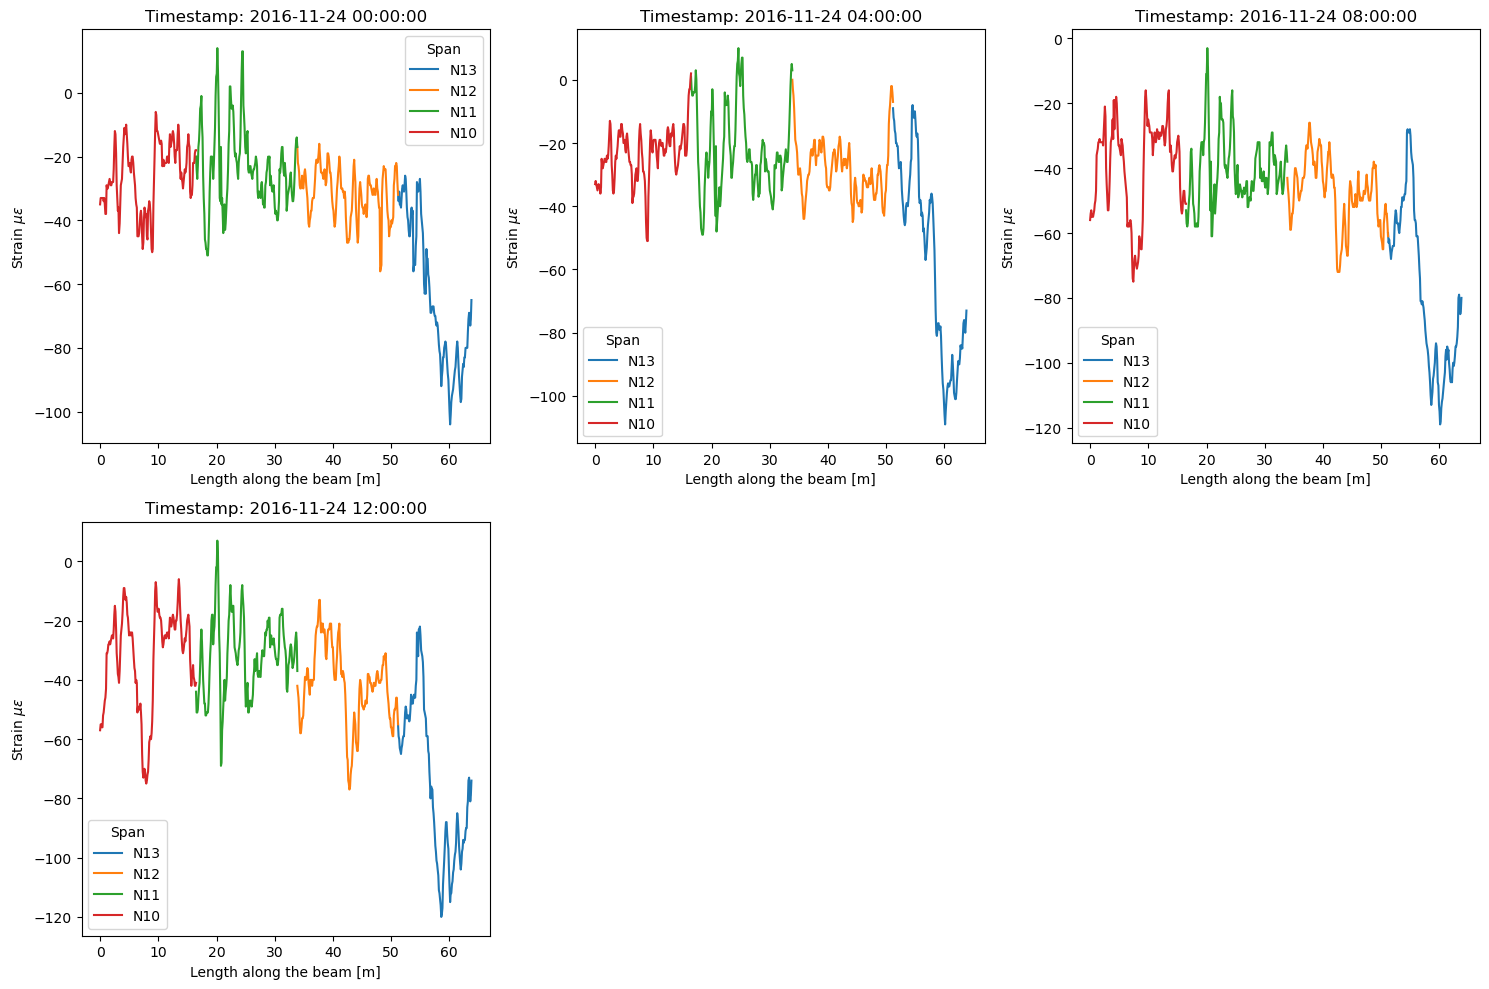

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime

def load_existing_folders(base_dir):
    """Return a list of folder names inside base_dir."""
    base_path = Path(base_dir)
    if not base_path.exists():
        raise FileNotFoundError(f"Base folder '{base_dir}' not found.")
    
    return sorted([folder.name for folder in base_path.iterdir() if folder.is_dir()])  # Sort for consistency

def plot_multiple_spans(base_dir, timestamps, file_name, cols):
    if not timestamps:
        raise ValueError("No timestamps provided.")
    
    timestamps = sorted(timestamps)  # Sort timestamps for consistency
    rows = math.ceil(len(timestamps) / cols)  # Calculate number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Create subplots
    axes = axes.flatten()  # Flatten axes array to simplify indexing

    for i, timestamp in enumerate(timestamps):
        df = read_text_file(base_dir, timestamp, file_name)
        if df is None:
            continue  # Skip if file is missing

        df = preprocess_dataframe(df)
        plot_span_data(df, axes[i], timestamp)

    for j in range(i + 1, len(axes)):  # Hide any empty subplots
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def read_text_file(base_dir, timestamp, file_name):
    """Reads a text file and returns a DataFrame."""
    file_path = Path(base_dir) / timestamp / file_name
    if not file_path.exists():
        print(f"Error: The file '{file_name}' does not exist in the folder '{file_path.parent}'.")
        return None

    data = []
    with file_path.open('r') as file:
        for line in file:
            parts = line.strip().split(',')
            processed_parts = parts[:2] + parts[2].split()
            data.append(processed_parts)

    df = pd.DataFrame(data)
    num_columns = df.shape[1]

    column_names = ["Span", "Beam"]
    if num_columns > 2:
        column_names.append("Coordinate")
    
    remaining_columns = [f"Column_{i+1}" for i in range(num_columns - len(column_names))]
    df.columns = column_names + remaining_columns

    df.drop(df.columns[[4,5]], axis=1, errors='ignore', inplace=True)
    df.rename(columns={'Column_1': 'Strain', 'Column_4': 'Temp', 'Column_5': 'Position'}, inplace=True)
    
    return df

def preprocess_dataframe(df):
    """Processes the DataFrame to adjust coordinates and spans."""
    df["Coordinate"] = pd.to_numeric(df["Coordinate"], errors="coerce")
    df["Strain"] = pd.to_numeric(df["Strain"], errors="coerce")
    df["Adjusted_Coordinate"] = df["Coordinate"].copy()
    
    df["Span_Number"] = df["Span"].str.extract(r'(\d+)').astype(float)
    span_order = df.groupby("Span")["Span_Number"].first().sort_values().index.tolist()

    offset = 0
    for span in span_order:
        span_mask = df["Span"] == span
        if span_mask.any():
            min_coord = df.loc[span_mask, "Coordinate"].min()
            df.loc[span_mask, "Adjusted_Coordinate"] += offset - min_coord
            offset = df.loc[span_mask, "Adjusted_Coordinate"].max()
    
    return df

def plot_span_data(df, ax, timestamp):
    """Plots span data on a given axis."""
    sns.lineplot(data=df, x="Adjusted_Coordinate", y="Strain", hue="Span", linestyle="-", ax=ax)
    ax.set_xlabel('Length along the beam [m]')
    ax.set_ylabel(r"Strain $\mu \epsilon$")
    ax.set_title(f"Timestamp: {datetime.strptime(timestamp, '%Y%m%d%H%M%S').strftime('%Y-%m-%d %H:%M:%S')}")

# Example usage
base_dir = RAW_DATA_DIR
file_name = "N-B_Far_Comp.txt"
timestamps = ['20161124000000', '20161124040000', '20161124080000', '20161124120000']

plot_multiple_spans(base_dir, timestamps, file_name, cols=3)

In [ ]:
# import random
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import math
# from datetime import datetime

# def load_existing_folders(RAW_DATA_DIR):
#     """Return a list of folder names inside RAW_DATA_DIR."""
#     try:
#         return sorted(os.listdir(RAW_DATA_DIR))  # Sort for consistency
#     except FileNotFoundError:
#         raise FileNotFoundError(f"Base folder '{RAW_DATA_DIR}' not found.")
    
# def plot_multiple_spans(timestamps, RAW_DATA_DIR, file_name, n):    

#     # if len(timestamps) < n:
#     #     raise ValueError(f"Only {len(timestamps)} timestamps available, but {n} were requested.")

#     selected_timestamps = random.sample(timestamps, n)
#     selected_timestamps = sorted(selected_timestamps)

#     cols = 4
#     rows = math.ceil(n / cols)  # Calculate rows needed

#     fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust figure size

#     # Flatten axes array to make indexing easier
#     axes = axes.flatten()

#     for i, timestamp in enumerate(selected_timestamps):
#         df = read_text_file(RAW_DATA_DIR, timestamp, file_name)
#         if df is None:
#             continue  # Skip if file is missing

#         df["Coordinate"] = pd.to_numeric(df["Coordinate"], errors="coerce")
#         df["Strain"] = pd.to_numeric(df["Strain"], errors="coerce")

#         # Define which columns to use for plotting, check the excel for what column
#         y_col = "Strain"   # Y-axis 

#         x_col = "Coordinate" 
#         df["Adjusted_Coordinate"] = df[x_col]  

#         df["Span_Number"] = df["Span"].str.extract(r'(\d+)').astype(float)
#         span_order = df.groupby("Span")["Span_Number"].first().sort_values().index.tolist()

#         offset = 0

#         for span in span_order:
#             span_mask = df["Span"] == span
#             if span_mask.any():
#                 min_coord = df.loc[span_mask, "Coordinate"].min()
#                 df.loc[span_mask, "Adjusted_Coordinate"] += offset - min_coord
#                 offset = df.loc[span_mask, "Adjusted_Coordinate"].max()

#         # Plot in subplot
#         sns.lineplot(data=df, x="Adjusted_Coordinate", y="Strain", hue="Span", linestyle="-", ax=axes[i])
#         axes[i].set_xlabel('Length along the beam [m]')
#         axes[i].set_ylabel(r"Strain $\mu \epsilon$")
#         axes[i].set_title(f"Timestamp: {datetime.strptime(timestamp, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")}")

#     plt.tight_layout()
#     plt.show()

# RAW_DATA_DIR = '../0_GAB'
# file_name = 'N-B_Far_Comp.txt'  # The file inside each timestamp folder
# n = 12  # Number of timestamps to randomly select
# # timestamps = load_existing_folders(RAW_DATA_DIR)
# # timestamps = ['20151124000000', '20151124040000', '20151124080000', '20151124120000', '20151124160000', '20151124200000', '20151125000000', '20151125040000', '20151125080000', '20151125120000', '20151125160000', '20151125200000']
# timestamps = ['20151124000000', '20151124040000', '20151124080000', '20151124120000']
# plot_multiple_spans(timestamps, RAW_DATA_DIR, file_name, n)
